# Analisis espacial

## Autor: Pedro Jose Leal

### Descripción de la Base de Datos: US-Accidents

Este es un conjunto de datos de accidentes automovilísticos a nivel nacional que abarca 49 estados de los EE. UU.. Los datos de los accidentes se recopilaron desde febrero de 2016 hasta marzo de 2023, utilizando múltiples API que proporcionan datos de incidentes de tráfico en tiempo real.

Estas API transmiten datos de tráfico capturados por diversas entidades, como los departamentos de transporte estatales y de EE. UU., agencias de aplicación de la ley, cámaras de tráfico y sensores de tráfico dentro de las redes de carreteras. Actualmente, hay aproximadamente 7.7 millones de registros de accidentes en este conjunto de datos.

Para el análisis de datos que se va a comenzar, solo se utilizarán las siguientes variables del conjunto de datos:

*   `ID`: Identificador único para cada registro de accidente.
*   `Start_Time`: Muestra la hora de inicio del accidente en la zona horaria local.
*   `Start_Lat`: Muestra la latitud en coordenadas GPS del punto de inicio del accidente.
*   `Start_Lng`: Muestra la longitud en coordenadas GPS del punto de inicio del accidente.
*   `Temperature(F)`: Indica la temperatura en grados Fahrenheit en el lugar del accidente.
*   `Humidity(%)`: Muestra la humedad en porcentaje.
*   `Pressure(in)`: Indica la presión atmosférica en pulgadas de mercurio.

## 1. Analisis de los datos

Cargando y filtrando el dataset...
Dataset cargado con 6985228 registros iniciales.

--- Limpieza Avanzada de Datos ---
Se eliminaron 164846 registros con valores nulos o cero.
El dataset final tiene 6820382 registros válidos.

--- Análisis de Estaciones ---
Hay 2753388 estaciones únicas en el dataset.

--- Análisis de Reportes por Hora ---
Generando diagrama de barras de reportes por hora...


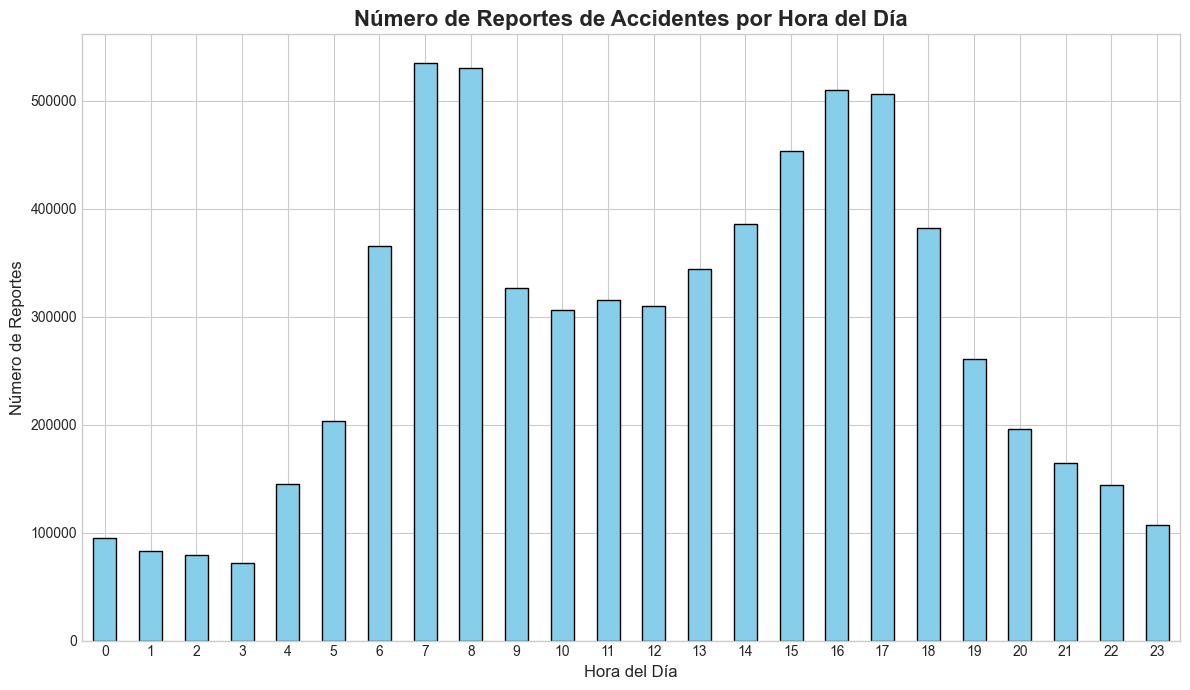


--- Generando Mapas de Calor con Coordenadas Planas ---
Creando GeoDataFrame a partir de Latitud y Longitud (EPSG:4326)...
Proyectando a coordenadas planas (Albers Equal Area - ESRI:102003)...


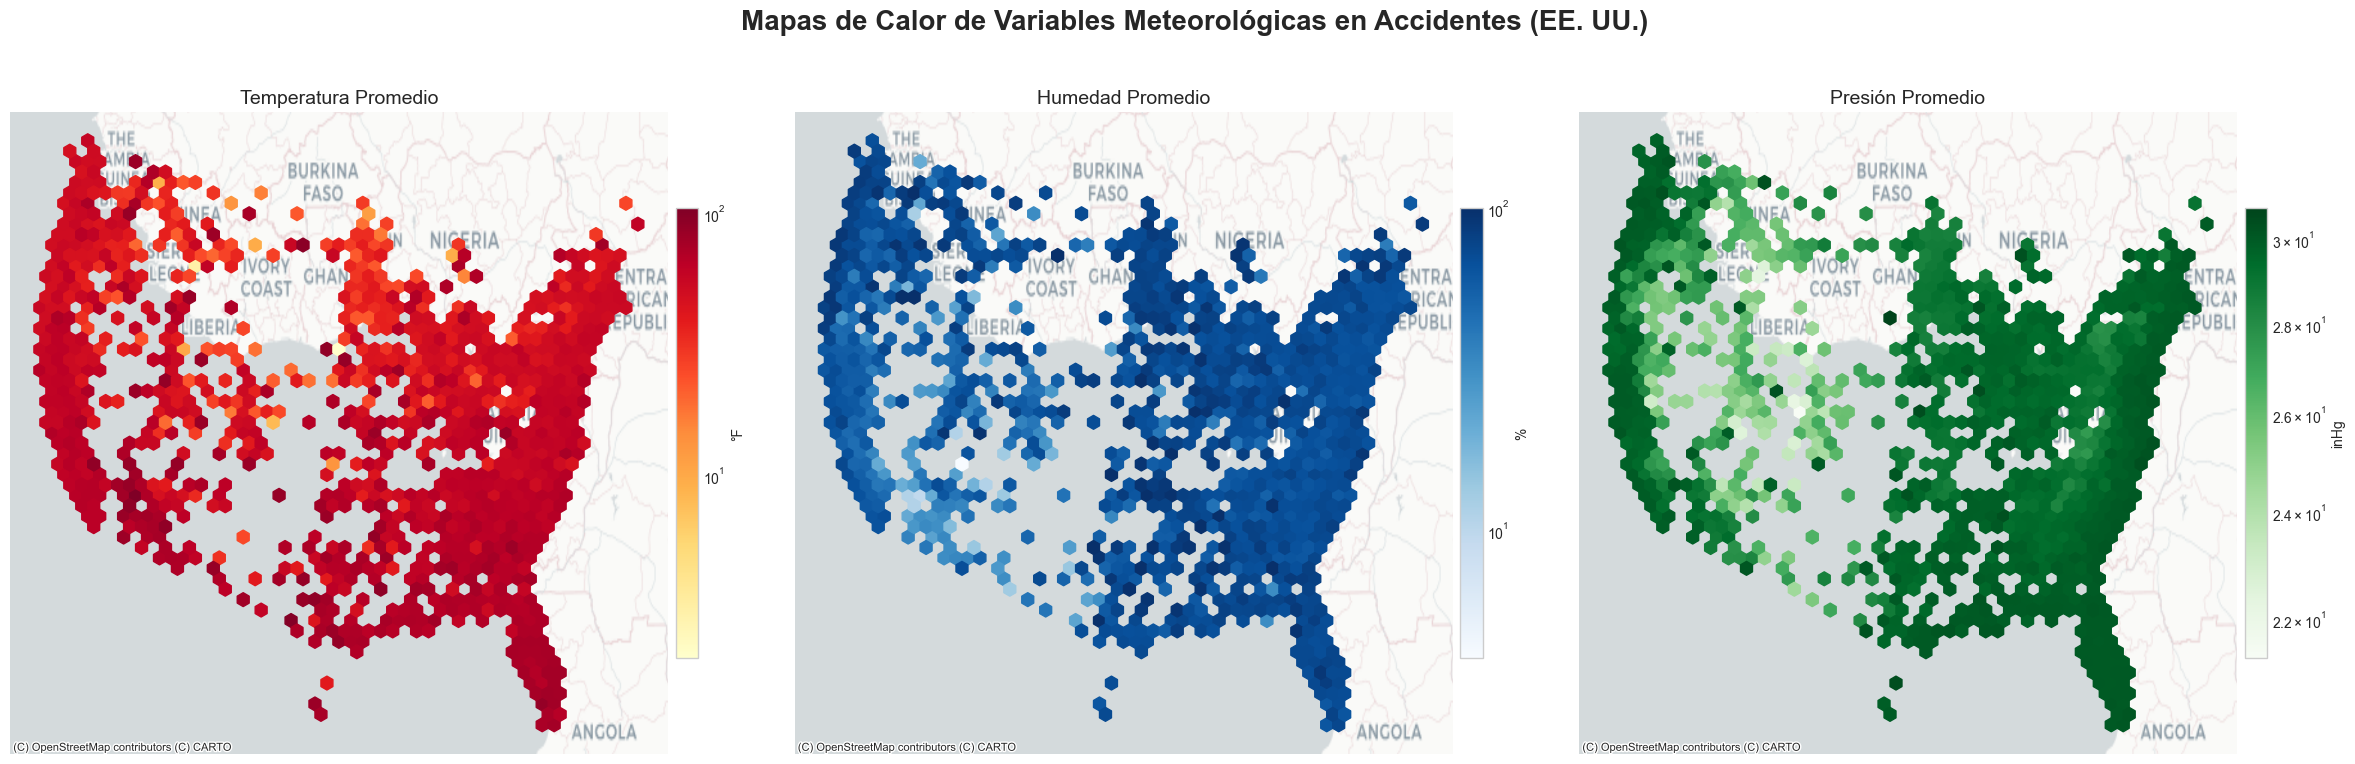

In [1]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np

# --- PASO 2: DEFINICIÓN DE FUNCIONES ---

# Las funciones cargar_y_preparar_datos, limpiar_datos_invalidos,
# analizar_estaciones y graficar_reportes_por_hora no necesitan cambios
# y se mantienen como en la versión anterior.

def cargar_y_preparar_datos(path, columnas):
    """
    Carga el dataset desde un archivo CSV, filtra por columnas y realiza una limpieza inicial.
    """
    print("Cargando y filtrando el dataset...")
    df = pd.read_csv(path, usecols=columnas)
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df.dropna(subset=['Start_Time', 'Start_Lat', 'Start_Lng'], inplace=True)
    print(f"Dataset cargado con {len(df)} registros iniciales.")
    return df

def limpiar_datos_invalidos(df, columnas_a_validar):
    """
    Elimina registros que contienen valores nulos o cero en columnas específicas.
    """
    print("\n--- Limpieza Avanzada de Datos ---")
    registros_antes = len(df)
    df.dropna(subset=columnas_a_validar, inplace=True)
    for col in columnas_a_validar:
        df = df[df[col].ne(0)]
    registros_despues = len(df)
    print(f"Se eliminaron {registros_antes - registros_despues} registros con valores nulos o cero.")
    print(f"El dataset final tiene {registros_despues} registros válidos.")
    return df

def analizar_estaciones(df):
    """
    Crea una columna 'estacion' y cuenta el número de estaciones únicas.
    """
    print("\n--- Análisis de Estaciones ---")
    df['estacion'] = df['Start_Lat'].astype(str) + ',' + df['Start_Lng'].astype(str)
    numero_de_estaciones = df['estacion'].nunique()
    print(f"Hay {numero_de_estaciones} estaciones únicas en el dataset.")
    return df

def graficar_reportes_por_hora(df):
    """
    Genera y muestra un diagrama de barras del número de reportes por hora.
    """
    print("\n--- Análisis de Reportes por Hora ---")
    df['Hour'] = df['Start_Time'].dt.hour
    reportes_por_hora = df['Hour'].value_counts().sort_index()
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    reportes_por_hora.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title('Número de Reportes de Accidentes por Hora del Día', fontsize=16, fontweight='bold')
    ax.set_xlabel('Hora del Día', fontsize=12)
    ax.set_ylabel('Número de Reportes', fontsize=12)
    ax.tick_params(axis='x', rotation=0)
    print("Generando diagrama de barras de reportes por hora...")
    plt.tight_layout()
    plt.show()

# --- FUNCIÓN MODIFICADA ---
def graficar_mapas_de_calor(df, sample_size=50000):
    """
    Proyecta las coordenadas a un sistema plano (Albers para EE. UU.) y genera mapas de calor.
    
    Args:
        df (pandas.DataFrame): DataFrame con datos geoespaciales y meteorológicos.
        sample_size (int): Número de muestras a usar para la visualización.
    """
    print("\n--- Generando Mapas de Calor con Coordenadas Planas ---")
    if len(df) < sample_size:
        sample_size = len(df)
    
    df_sample = df.sample(n=sample_size, random_state=42)
    
    print("Creando GeoDataFrame a partir de Latitud y Longitud (EPSG:4326)...")
    geometry = [Point(xy) for xy in zip(df_sample['Start_Lng'], df_sample['Start_Lat'])]
    gdf = gpd.GeoDataFrame(df_sample, geometry=geometry, crs="EPSG:4326")

    # --- CAMBIO CLAVE: Proyección a Coordenadas Planas ---
    # Se convierte de coordenadas geográficas (lat/lon) a la proyección Albers para EE.UU.
    # El resultado son coordenadas X,Y en metros, que son las coordenadas planas "Este" y "Norte".
    print("Proyectando a coordenadas planas (Albers Equal Area - ESRI:102003)...")
    gdf = gdf.to_crs("ESRI:102003")
    
    # --- NUEVO: Extraer coordenadas planas a columnas 'Este' y 'Norte' ---
    gdf['Este'] = gdf.geometry.x
    gdf['Norte'] = gdf.geometry.y

    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
    plt.suptitle('Mapas de Calor de Variables Meteorológicas en Accidentes (EE. UU.)', fontsize=20, fontweight='bold')

    variables = {
        'Temperatura': ('Temperature(F)', 'YlOrRd', '°F'),
        'Humedad': ('Humidity(%)', 'Blues', '%'),
        'Presión': ('Pressure(in)', 'Greens', 'inHg')
    }
    
    for i, (nombre, (col, cmap, label)) in enumerate(variables.items()):
        ax = axes[i]
        # Ahora usamos las nuevas coordenadas planas 'Este' y 'Norte' para el gráfico
        hb = ax.hexbin(gdf['Este'], gdf['Norte'], C=gdf[col], reduce_C_function=np.mean, gridsize=50, cmap=cmap, bins='log')
        ax.set_title(f'{nombre} Promedio', fontsize=14)
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
        cb = fig.colorbar(hb, ax=ax, orientation='vertical', pad=0.01, shrink=0.7)
        cb.set_label(label)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- PASO 3: EJECUCIÓN PRINCIPAL DEL SCRIPT ---

# --- CONFIGURACIÓN ---
path_al_archivo_csv = "./Datos/US_Accidents_March23.csv"
columnas_fundamentales = ['ID', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)']
columnas_a_validar = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)']

# --- FLUJO DE TRABAJO ---
# 1. Cargar datos
df = cargar_y_preparar_datos(path_al_archivo_csv, columnas_fundamentales)
    
# 2. Limpiar valores nulos y ceros
df_limpio = limpiar_datos_invalidos(df, columnas_a_validar)
    
# 3. Analizar y contar estaciones
df_con_estaciones = analizar_estaciones(df_limpio)
    
# 4. Graficar reportes por hora
graficar_reportes_por_hora(df_con_estaciones)
    
# 5. Graficar mapas de calor (usando la nueva función con proyección)
graficar_mapas_de_calor(df_con_estaciones)

## 2. Paso a coordenadas cuadradas y selección de la hora

Se ha creado un DataFrame 'df_7am' con 534767 registros para las 7:00.
Convirtiendo coordenadas geográficas a coordenadas planas (Este/Norte)...
Proyección completada.

Filtrando estaciones dentro del box:
  Este: [1800000m, 2000000m]
  Norte: [700000m, 800000m]
Se han encontrado 3172 registros dentro del box especificado.
Este DataFrame 'df_box_filtered' se usará para todos los análisis siguientes.

Generando el gráfico de ubicación 2D con mapa OSM y el box resaltado...


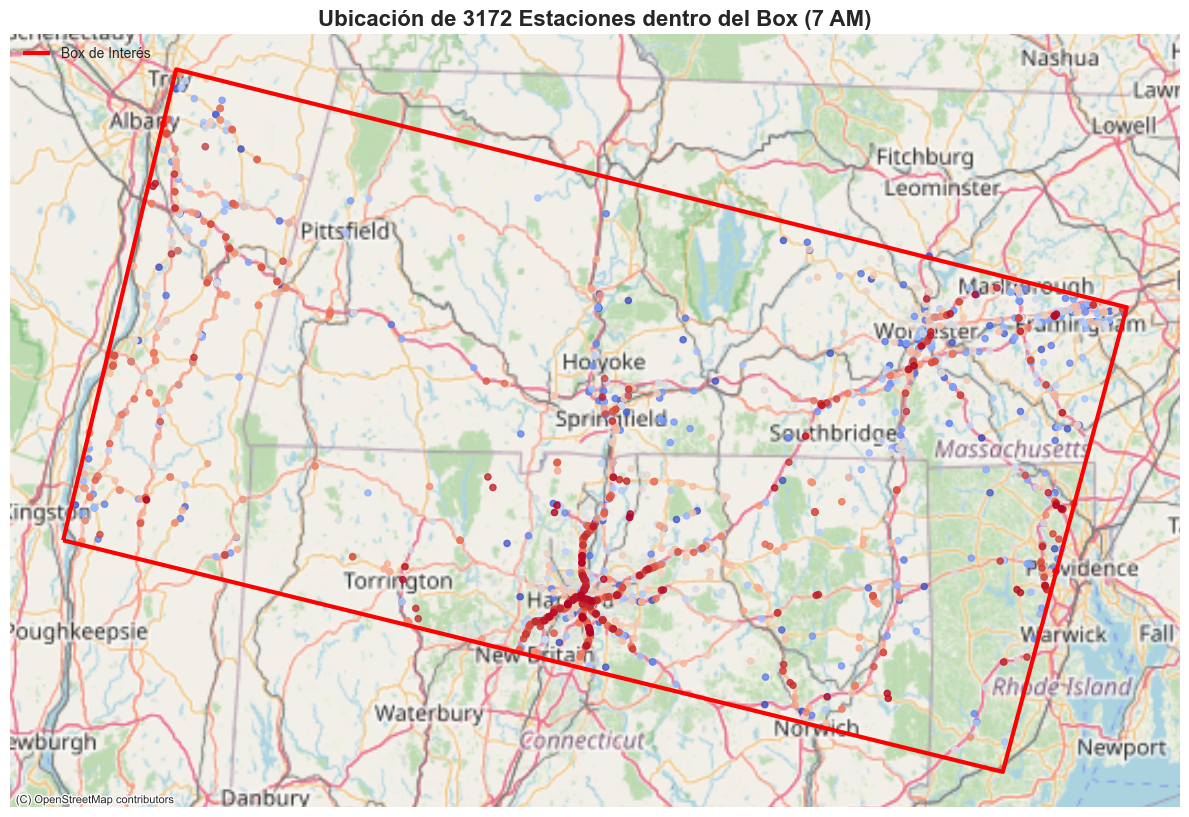


Generando los gráficos de dispersión 3D...


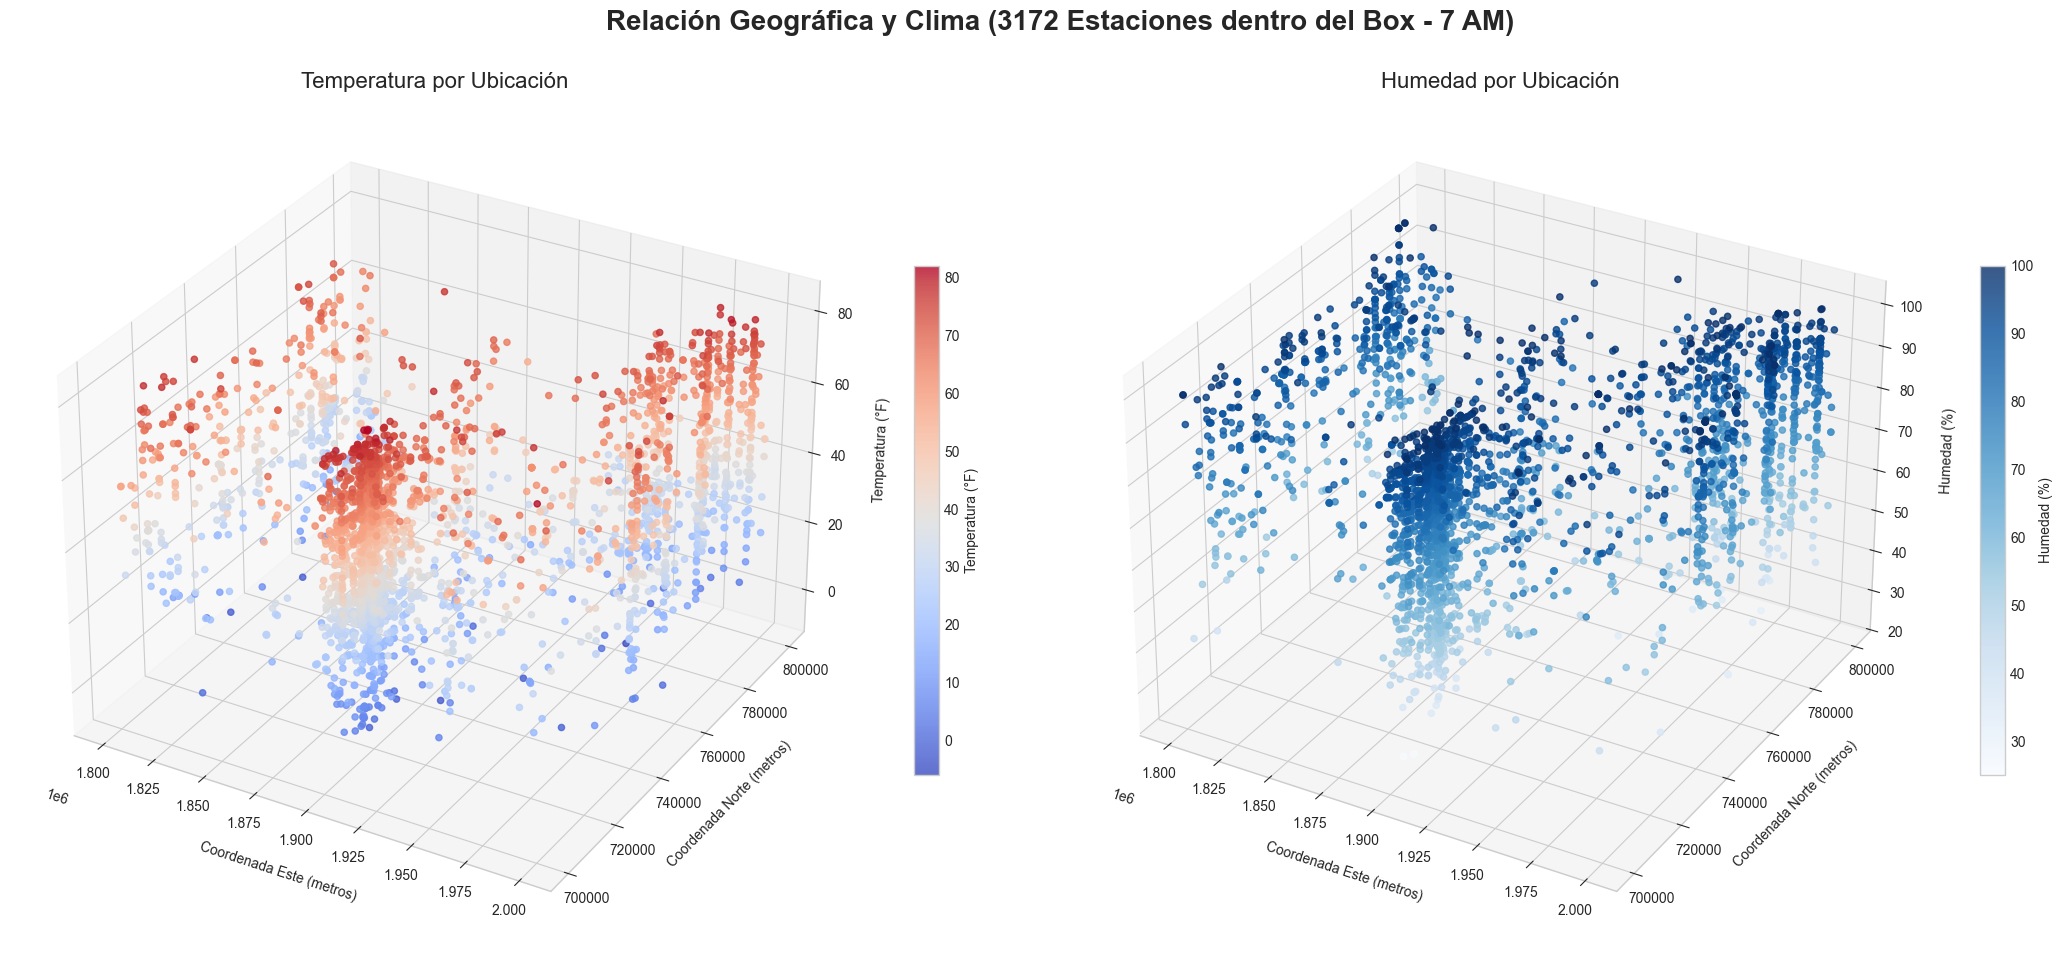


--- ANÁLISIS BIVARIADO CON MATRIZ DE DISPERSIÓN ---
Generando la matriz de dispersión para las 3172 estaciones dentro del box...


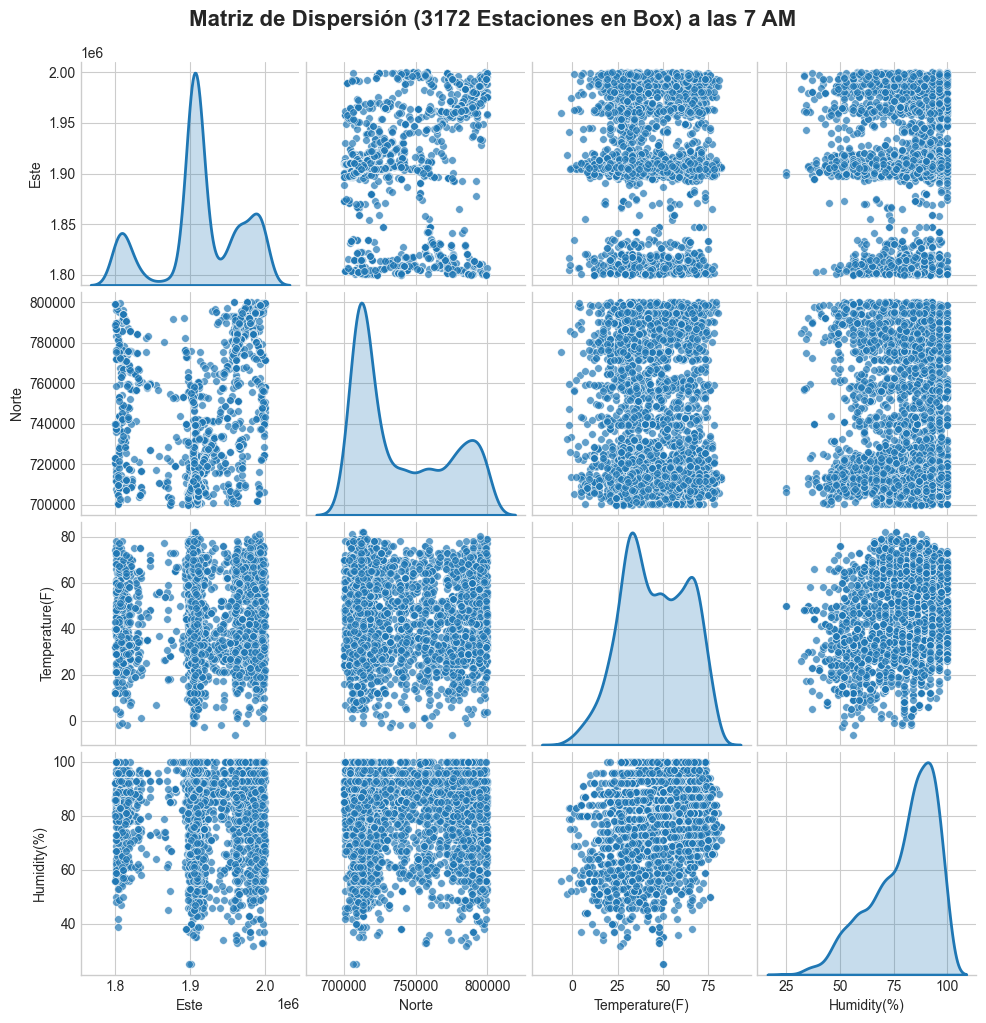


Análisis completado. El DataFrame 'df_box_filtered' con 3172 registros está listo para su uso.


In [2]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon # Agregamos Polygon para el box
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import contextily as cx # Para el mapa base de OpenStreetMap

# --- PASO 2: FILTRADO Y PROYECCIÓN DE DATOS (7 AM) ---
# Se asume que 'df_con_estaciones' ya existe desde la ejecución de celdas anteriores.

hora_de_interes = 7
df_7am = df_con_estaciones[df_con_estaciones['Start_Time'].dt.hour == hora_de_interes].copy()

print(f"Se ha creado un DataFrame 'df_7am' con {len(df_7am)} registros para las {hora_de_interes}:00.")

# --- Proyección a Coordenadas Planas ---
print("Convirtiendo coordenadas geográficas a coordenadas planas (Este/Norte)...")
geometry = [Point(xy) for xy in zip(df_7am['Start_Lng'], df_7am['Start_Lat'])]
gdf_7am = gpd.GeoDataFrame(df_7am, geometry=geometry, crs="EPSG:4326")

# Proyectamos a Albers Equal Area para EE.UU.
# Este CRS es útil para análisis espaciales y distancias en metros.
gdf_7am_proyectado = gdf_7am.to_crs("ESRI:102003")

# Extraemos las coordenadas planas (en metros) a nuevas columnas.
gdf_7am_proyectado['Este'] = gdf_7am_proyectado.geometry.x
gdf_7am_proyectado['Norte'] = gdf_7am_proyectado.geometry.y
print("Proyección completada.")

# --- PASO 3: FILTRADO DENTRO DEL "BOX" ESPECIFICADO ---

# Definimos las coordenadas del box en metros (proyección ESRI:102003)
min_este = 1.8e6
max_este = 2e6
min_norte = 0.7e6
max_norte = 0.8e6

print(f"\nFiltrando estaciones dentro del box:")
print(f"  Este: [{min_este:.0f}m, {max_este:.0f}m]")
print(f"  Norte: [{min_norte:.0f}m, {max_norte:.0f}m]")

# Aplicamos el filtro
gdf_box_filtered = gdf_7am_proyectado[
    (gdf_7am_proyectado['Este'] >= min_este) &
    (gdf_7am_proyectado['Este'] <= max_este) &
    (gdf_7am_proyectado['Norte'] >= min_norte) &
    (gdf_7am_proyectado['Norte'] <= max_norte)
].copy()

# Preparamos el DataFrame definitivo para los gráficos posteriores
# Solo seleccionamos las columnas necesarias para el análisis.
columnas_para_analisis = ['Este', 'Norte', 'Temperature(F)', 'Humidity(%)']
df_box_filtered = gdf_box_filtered[columnas_para_analisis].dropna()

print(f"Se han encontrado {len(df_box_filtered)} registros dentro del box especificado.")
print("Este DataFrame 'df_box_filtered' se usará para todos los análisis siguientes.")


# --- PASO 4: (NUEVO) VISUALIZACIÓN GEOGRÁFICA 2D CON MAPA OSM Y BOX ---
print("\nGenerando el gráfico de ubicación 2D con mapa OSM y el box resaltado...")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Para el mapa base de contextily, el GeoDataFrame debe estar en Web Mercator (EPSG:3857)
# Proyectamos temporalmente los puntos para el mapa
gdf_box_filtered_webmercator = gdf_box_filtered.to_crs(epsg=3857)

# Graficamos los puntos filtrados
gdf_box_filtered_webmercator.plot(
    ax=ax,
    marker='o',
    c=gdf_box_filtered_webmercator['Temperature(F)'], # Coloreamos por temperatura
    cmap='coolwarm',
    markersize=20,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': "Temperatura (°F)", 'orientation': "vertical"}
)

# Creamos la geometría del box para dibujarla en el mapa
bbox_polygon = Polygon([
    (min_este, min_norte),
    (max_este, min_norte),
    (max_este, max_norte),
    (min_este, max_norte),
    (min_este, min_norte) # Cerrar el polígono
])
gdf_bbox_poly = gpd.GeoDataFrame([1], geometry=[bbox_polygon], crs="ESRI:102003")

# Proyectamos el box al CRS de Web Mercator para que coincida con el mapa base
gdf_bbox_poly_webmercator = gdf_bbox_poly.to_crs(epsg=3857)

# Graficamos el box
gdf_bbox_poly_webmercator.boundary.plot(ax=ax, color='red', linewidth=3, label='Box de Interés')

# Añadimos el mapa base de OpenStreetMap
cx.add_basemap(ax, crs=gdf_box_filtered_webmercator.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title(f'Ubicación de {len(df_box_filtered)} Estaciones dentro del Box (7 AM)', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitud (Web Mercator)', fontsize=12)
ax.set_ylabel('Latitud (Web Mercator)', fontsize=12)
ax.legend(loc='upper left')
plt.axis('off') # Opcional: para quitar los ejes de coordenadas del mapa base
plt.tight_layout()
plt.show()


# --- PASO 5: CREACIÓN DE LOS GRÁFICOS DE DISPERSIÓN 3D ---
print("\nGenerando los gráficos de dispersión 3D...")

fig = plt.figure(figsize=(22, 10))
plt.suptitle(f'Relación Geográfica y Clima ({len(df_box_filtered)} Estaciones dentro del Box - 7 AM)', fontsize=20, fontweight='bold')

# --- Gráfico 1: Temperatura ---
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    df_box_filtered['Este'], df_box_filtered['Norte'], df_box_filtered['Temperature(F)'],
    c=df_box_filtered['Temperature(F)'], cmap='coolwarm', s=20, alpha=0.8
)
ax1.set_title('Temperatura por Ubicación', fontsize=16)
ax1.set_xlabel('Coordenada Este (metros)', fontsize=10, labelpad=10)
ax1.set_ylabel('Coordenada Norte (metros)', fontsize=10, labelpad=10)
ax1.set_zlabel('Temperatura (°F)', fontsize=10, labelpad=10)
fig.colorbar(sc1, ax=ax1, shrink=0.6, label='Temperatura (°F)')

# --- Gráfico 2: Humedad ---
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    df_box_filtered['Este'], df_box_filtered['Norte'], df_box_filtered['Humidity(%)'],
    c=df_box_filtered['Humidity(%)'], cmap='Blues', s=20, alpha=0.8
)
ax2.set_title('Humedad por Ubicación', fontsize=16)
ax2.set_xlabel('Coordenada Este (metros)', fontsize=10, labelpad=10)
ax2.set_ylabel('Coordenada Norte (metros)', fontsize=10, labelpad=10)
ax2.set_zlabel('Humedad (%)', fontsize=10, labelpad=10)
fig.colorbar(sc2, ax=ax2, shrink=0.6, label='Humedad (%)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- PASO 6: CREACIÓN DE LA MATRIZ DE DISPERSIÓN (PAIRPLOT) ---
print("\n" + "="*50)
print("--- ANÁLISIS BIVARIADO CON MATRIZ DE DISPERSIÓN ---")
print("="*50)
print(f"Generando la matriz de dispersión para las {len(df_box_filtered)} estaciones dentro del box...")

# Configuramos el estilo de Seaborn.
sns.set_style("whitegrid")

# Creamos el pairplot usando el DataFrame df_box_filtered
pair_plot = sns.pairplot(
    df_box_filtered,
    vars=['Este', 'Norte', 'Temperature(F)', 'Humidity(%)'],
    kind='scatter',
    diag_kind='kde',
    plot_kws={'alpha': 0.7, 's': 30},
    diag_kws={'linewidth': 2}
)

# Añadimos un título general a la figura.
pair_plot.fig.suptitle(f'Matriz de Dispersión ({len(df_box_filtered)} Estaciones en Box) a las 7 AM', y=1.02, fontsize=16, fontweight='bold')

plt.show()

# --- CONFIRMACIÓN FINAL ---
print(f"\nAnálisis completado. El DataFrame 'df_box_filtered' con {len(df_box_filtered)} registros está listo para su uso.")

## 3. Analisis de modelos de tendencia

In [3]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Para suprimir advertencias de Singular Matrix en PolyFeatures

# --- PASO 2: PREPARACIÓN DE DATOS PARA EL MODELADO ---
# Se utiliza el DataFrame 'df_box_filtered' creado en la celda anterior.
# Este DataFrame ya contiene solo los datos de las 7 AM dentro del box geográfico
# y ya ha sido limpiado de valores nulos (NaN).

print("Preparando datos para el modelado usando el DataFrame 'df_box_filtered'...")

# El DataFrame 'df_box_filtered' ya tiene las columnas necesarias:
# ['Este', 'Norte', 'Temperature(F)', 'Humidity(%)']
df_model = df_box_filtered.copy() # Usamos una copia para buenas prácticas

# Definir las variables predictoras (X) y las variables objetivo (y)
# X son las coordenadas planas del área de interés (el box).
X = df_model[['Este', 'Norte']]
y_temp = df_model['Temperature(F)']
y_hum = df_model['Humidity(%)']

# Dividir los datos en conjuntos de entrenamiento (80%) y prueba (20%) para la temperatura
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X, y_temp, test_size=0.2, random_state=42
)

# Dividir los datos para la humedad (usando el mismo 'random_state' para consistencia)
X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(
    X, y_hum, test_size=0.2, random_state=42
)

print(f"Datos listos. Usando {len(X_train_temp)} registros para entrenar y {len(X_test_temp)} para probar.")


# --- PASO 3: FUNCIÓN PARA AJUSTAR Y EVALUAR LOS MODELOS ---
# (Esta función no necesita cambios, ya que es genérica y funciona con los datos de entrada)
results = {}

def fit_and_evaluate(model_type, X_train, y_train, X_test, y_test, target_variable_name):
    """
    Ajusta un modelo, lo evalúa y muestra su R^2.
    """
    if model_type == 'simple':
        poly_features = PolynomialFeatures(degree=1, include_bias=False)
    elif model_type == 'interaccion':
        poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    elif model_type == 'polinomial':
        poly_features = PolynomialFeatures(degree=2, include_bias=False)

    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred = model.predict(X_test_poly)
    r2 = r2_score(y_test, y_pred)

    print(f"Modelo: {model_type.capitalize():<12} | R^2 = {r2:.4f}")

    if target_variable_name not in results:
        results[target_variable_name] = []
    results[target_variable_name].append({'modelo': model_type.capitalize(), 'R2': r2})

# --- PASO 4: EJECUCIÓN PARA TEMPERATURA ---
print("\n--- AJUSTE DE MODELOS PARA LA TEMPERATURA (DATOS DEL BOX) ---")
fit_and_evaluate('simple', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')
fit_and_evaluate('interaccion', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')
fit_and_evaluate('polinomial', X_train_temp, y_train_temp, X_test_temp, y_test_temp, 'Temperatura')

# --- PASO 5: EJECUCIÓN PARA HUMEDAD ---
print("\n--- AJUSTE DE MODELOS PARA LA HUMEDAD (DATOS DEL BOX) ---")
fit_and_evaluate('simple', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')
fit_and_evaluate('interaccion', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')
fit_and_evaluate('polinomial', X_train_hum, y_train_hum, X_test_hum, y_test_hum, 'Humedad')

# --- PASO 6: CONCLUSIÓN ---
print("\n--- CONCLUSIÓN (DATOS DEL BOX) ---")
for var, res in results.items():
    best_model = max(res, key=lambda x: x['R2'])
    print(f"Para la {var}, el mejor modelo es el '{best_model['modelo']}' con un R^2 de {best_model['R2']:.4f}.")

Preparando datos para el modelado usando el DataFrame 'df_box_filtered'...
Datos listos. Usando 2537 registros para entrenar y 635 para probar.

--- AJUSTE DE MODELOS PARA LA TEMPERATURA (DATOS DEL BOX) ---
Modelo: Simple       | R^2 = 0.0027
Modelo: Interaccion  | R^2 = 0.0153
Modelo: Polinomial   | R^2 = 0.0179

--- AJUSTE DE MODELOS PARA LA HUMEDAD (DATOS DEL BOX) ---
Modelo: Simple       | R^2 = -0.0101
Modelo: Interaccion  | R^2 = -0.0131
Modelo: Polinomial   | R^2 = -0.0120

--- CONCLUSIÓN (DATOS DEL BOX) ---
Para la Temperatura, el mejor modelo es el 'Polinomial' con un R^2 de 0.0179.
Para la Humedad, el mejor modelo es el 'Simple' con un R^2 de -0.0101.


## 4. Aplicación del modelo de tendencia y obtención de los residuos

Usando el DataFrame 'df_box_filtered' para el análisis...
Se usará una muestra de 3000 puntos para las visualizaciones 3D.

--- ANÁLISIS COMPLETO PARA TEMPERATURA (DATOS DEL BOX) ---
Modelo polinomial de grado 2 entrenado.


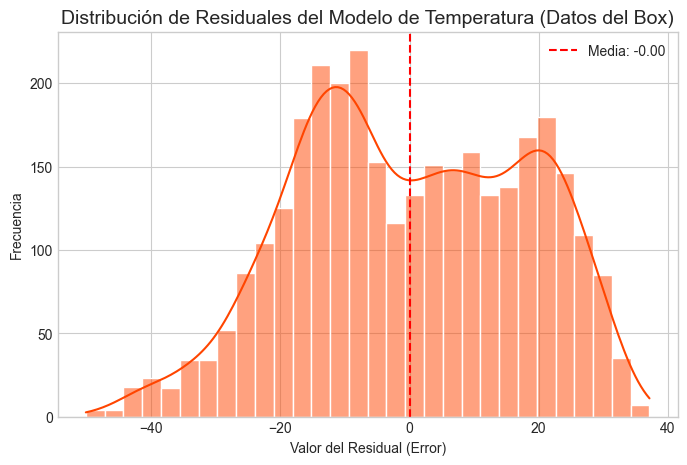

Generando visualización 3D estática de ajuste para 'Temperature(F)'...


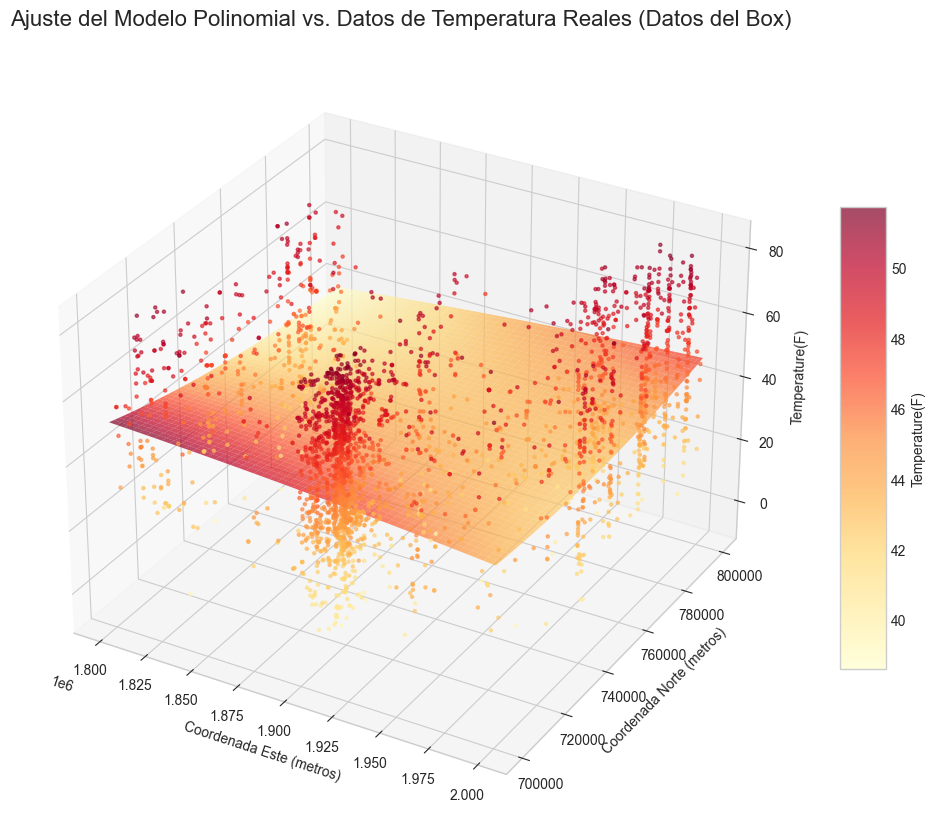


--- ANÁLISIS COMPLETO PARA HUMEDAD (DATOS DEL BOX) ---
Modelo polinomial de grado 2 entrenado.


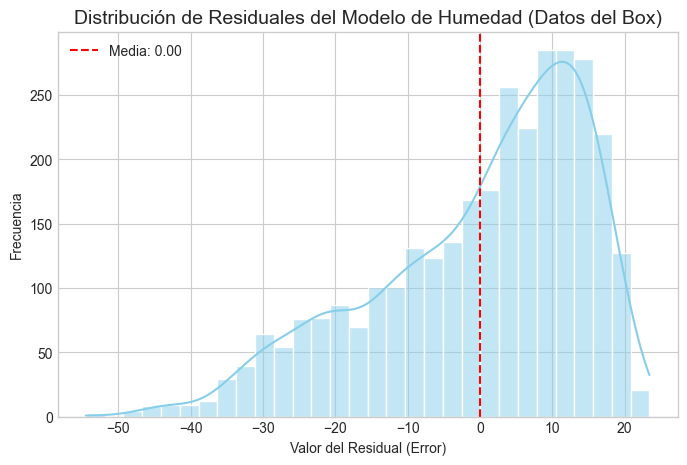

Generando visualización 3D estática de ajuste para 'Humidity(%)'...


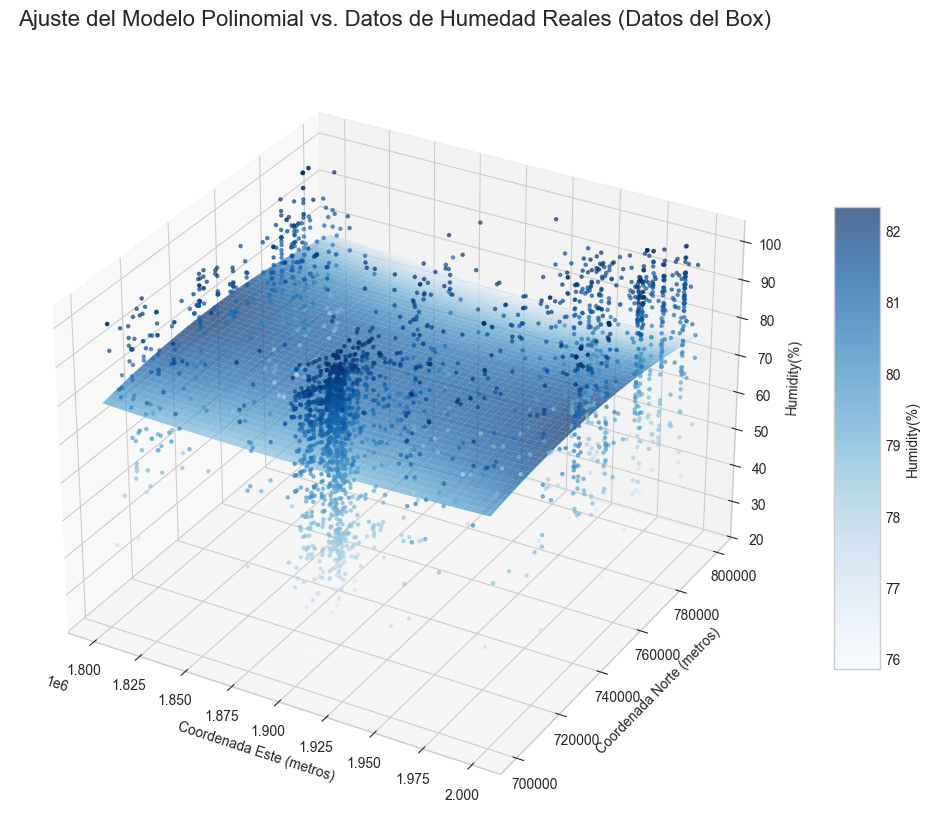


--- GENERANDO EL DATAFRAME FINAL 'df_base' ---
DataFrame 'df_base' creado con las columnas de residuales.
                Este          Norte  Temperature(F)  Humidity(%)  \
194347  1.914514e+06  708913.092137            44.1        100.0   
194353  1.905259e+06  728209.210171            45.0         93.0   
194374  1.909768e+06  718532.842049            46.0        100.0   
194383  1.962572e+06  784620.461570            43.0         93.0   
194388  1.907818e+06  709360.855176            46.0        100.0   

        res_temperatura  res_humedad  
194347        -2.767494    20.392624  
194353         0.066587    12.055821  
194374         0.160544    19.586161  
194383        -1.846921    14.525832  
194388        -1.041203    20.375604  

--- ANÁLISIS DE CORRELACIÓN ESPACIAL DE RESIDUALES (DATOS DEL BOX) ---
Generando matriz de dispersión (pairplot) de los residuales y la ubicación...


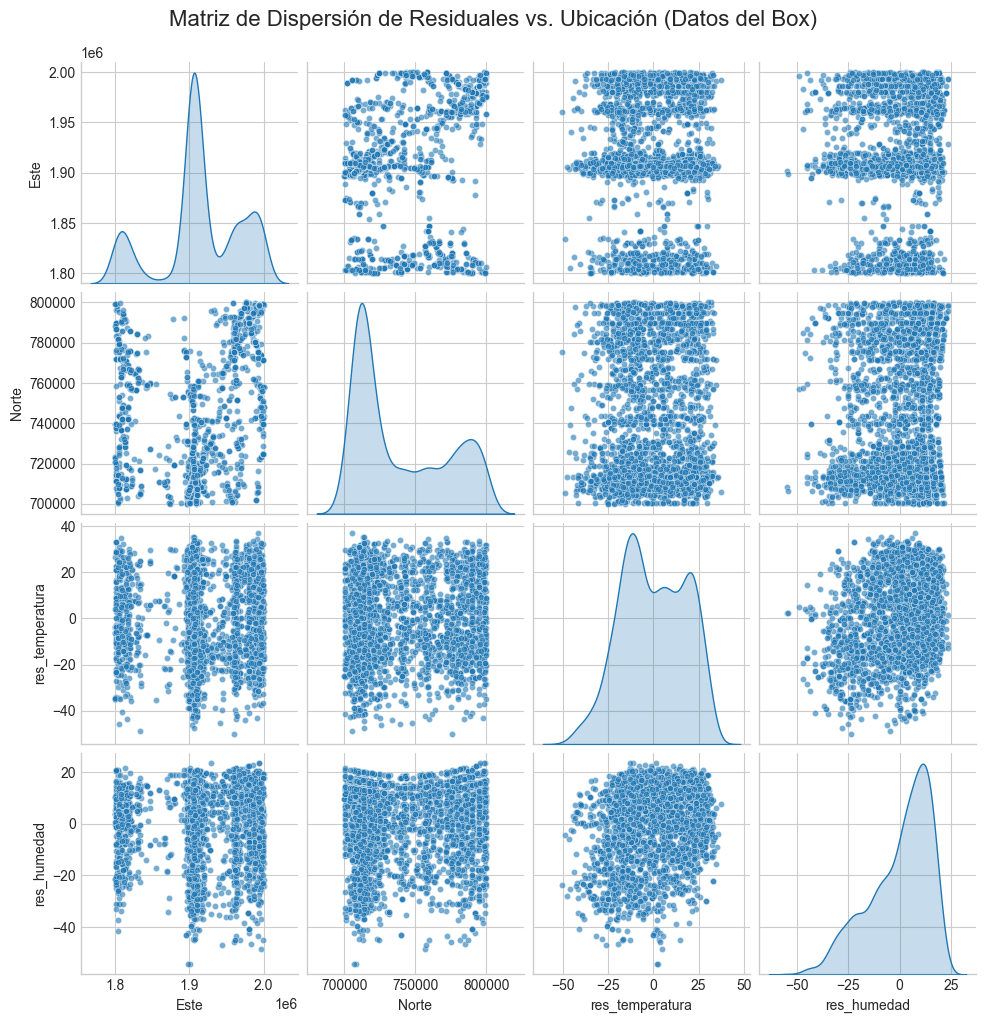

In [4]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# --- PASO 2: DEFINICIÓN DE FUNCIONES MODULARIZADAS ---
# (Estas funciones son genéricas y no necesitan cambios)

def train_polynomial_model(X_data, y_data, degree=2):
    """
    Entrena un modelo de regresión polinomial y devuelve el modelo y el objeto de características.
    """
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X_data)
    
    model = LinearRegression()
    model.fit(X_poly, y_data)
    
    print(f"Modelo polinomial de grado {degree} entrenado.")
    return model, poly_features

def calculate_residuals(model, poly_features, X_full, y_full):
    """
    Usa un modelo entrenado para predecir valores y calcular los residuales.
    Residual = Valor Real - Valor Predicho
    """
    X_poly = poly_features.transform(X_full)
    y_pred = model.predict(X_poly)
    residuals = y_full - y_pred
    return residuals

def plot_residuals_distribution(residuals, title, color):
    """
    Crea un histograma con una curva de densidad para visualizar la distribución de los residuales.
    """
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, color=color, bins=30) # Ajustado bins para un set de datos potencialmente más pequeño
    mean_res = residuals.mean()
    plt.axvline(mean_res, color='red', linestyle='--', label=f'Media: {mean_res:.2f}')
    plt.title(title, fontsize=14)
    plt.xlabel('Valor del Residual (Error)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_model_fit_3d_static(model, poly_features, df_sample, x_col, y_col, z_col, title, cmap):
    """
    Crea una visualización 3D estática que muestra los datos reales y la superficie del modelo.
    """
    print(f"Generando visualización 3D estática de ajuste para '{z_col}'...")
    
    # Preparar la malla para la superficie del modelo
    x_points = df_sample[x_col].values
    y_points = df_sample[y_col].values
    grid_x, grid_y = np.mgrid[x_points.min():x_points.max():100j, y_points.min():y_points.max():100j]
    
    grid_points_flat = np.c_[grid_x.ravel(), grid_y.ravel()]
    grid_poly_features = poly_features.transform(grid_points_flat)
    grid_z = model.predict(grid_poly_features).reshape(grid_x.shape)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Graficamos todos los puntos en df_sample (no solo los puntos de la malla)
    ax.scatter(df_sample[x_col], df_sample[y_col], df_sample[z_col], c=df_sample[z_col], cmap=cmap, marker='.', alpha=0.6)
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap=cmap, alpha=0.7, edgecolor='none')
    
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('Coordenada Este (metros)'); ax.set_ylabel('Coordenada Norte (metros)'); ax.set_zlabel(z_col)
    fig.colorbar(surf, shrink=0.6, aspect=10, label=z_col)
    
    plt.show()

# --- PASO 3: EJECUCIÓN PRINCIPAL DEL ANÁLISIS ---
# --- CORRECCIÓN: Usar df_box_filtered como base para el análisis ---
print("Usando el DataFrame 'df_box_filtered' para el análisis...")
df_model = df_box_filtered.copy() # Usamos el DataFrame filtrado por el box

# Definir variables predictoras (X) y objetivos (y)
X = df_model[['Este', 'Norte']]
y_temp = df_model['Temperature(F)']
y_hum = df_model['Humidity(%)']

# Usar una muestra para la visualización 3D. Si hay menos de 3000 puntos, los usa todos.
sample_size = min(3000, len(df_model))
df_sample = df_model.sample(n=sample_size, random_state=42)
print(f"Se usará una muestra de {sample_size} puntos para las visualizaciones 3D.")

# --- ANÁLISIS PARA TEMPERATURA ---
print("\n" + "="*50)
print("--- ANÁLISIS COMPLETO PARA TEMPERATURA (DATOS DEL BOX) ---")
print("="*50)
model_temp, poly_features_temp = train_polynomial_model(X, y_temp)
temp_residuals = calculate_residuals(model_temp, poly_features_temp, X, y_temp)

plot_residuals_distribution(
    residuals=temp_residuals,
    title='Distribución de Residuales del Modelo de Temperatura (Datos del Box)',
    color='orangered'
)
plot_model_fit_3d_static(
    model=model_temp, poly_features=poly_features_temp, df_sample=df_sample,
    x_col='Este', y_col='Norte', z_col='Temperature(F)',
    title='Ajuste del Modelo Polinomial vs. Datos de Temperatura Reales (Datos del Box)',
    cmap='YlOrRd'
)

# --- ANÁLISIS PARA HUMEDAD ---
print("\n" + "="*50)
print("--- ANÁLISIS COMPLETO PARA HUMEDAD (DATOS DEL BOX) ---")
print("="*50)
model_hum, poly_features_hum = train_polynomial_model(X, y_hum)
hum_residuals = calculate_residuals(model_hum, poly_features_hum, X, y_hum)

plot_residuals_distribution(
    residuals=hum_residuals,
    title='Distribución de Residuales del Modelo de Humedad (Datos del Box)',
    color='skyblue'
)
plot_model_fit_3d_static(
    model=model_hum, poly_features=poly_features_hum, df_sample=df_sample,
    x_col='Este', y_col='Norte', z_col='Humidity(%)',
    title='Ajuste del Modelo Polinomial vs. Datos de Humedad Reales (Datos del Box)',
    cmap='Blues'
)

# --- PASO 4: CREACIÓN DEL DATAFRAME FINAL CON LOS RESIDUALES ---
print("\n" + "="*50)
print("--- GENERANDO EL DATAFRAME FINAL 'df_base' ---")
print("="*50)

# df_base contendrá los datos originales del box más los residuales del modelo
df_base = df_model.copy()
df_base['res_temperatura'] = temp_residuals
df_base['res_humedad'] = hum_residuals

print("DataFrame 'df_base' creado con las columnas de residuales.")
print(df_base.head())


# --- PASO 5: (NUEVO) VISUALIZACIÓN PAIRPLOT DE LOS RESIDUALES ---
print("\n" + "="*50)
print("--- ANÁLISIS DE CORRELACIÓN ESPACIAL DE RESIDUALES (DATOS DEL BOX) ---")
print("="*50)

# Tomar una muestra del DataFrame final para una visualización más ágil
# De nuevo, si hay menos de 3000 puntos, los usa todos.
sample_size_res = min(3000, len(df_base))
df_sample_res = df_base.sample(n=sample_size_res, random_state=42)

print("Generando matriz de dispersión (pairplot) de los residuales y la ubicación...")

pair_plot_res = sns.pairplot(
    df_sample_res,
    vars=['Este', 'Norte', 'res_temperatura', 'res_humedad'],
    kind='scatter',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 20}
)
pair_plot_res.fig.suptitle('Matriz de Dispersión de Residuales vs. Ubicación (Datos del Box)', y=1.02, fontsize=16)
plt.show()

## 5 Semivariograma

Preparando datos para el análisis de semivariograma...
Datos listos. Se analizarán 3172 puntos.

--- SEMIVARIOGRAMA PARA LOS RESIDUALES DE TEMPERATURA ---


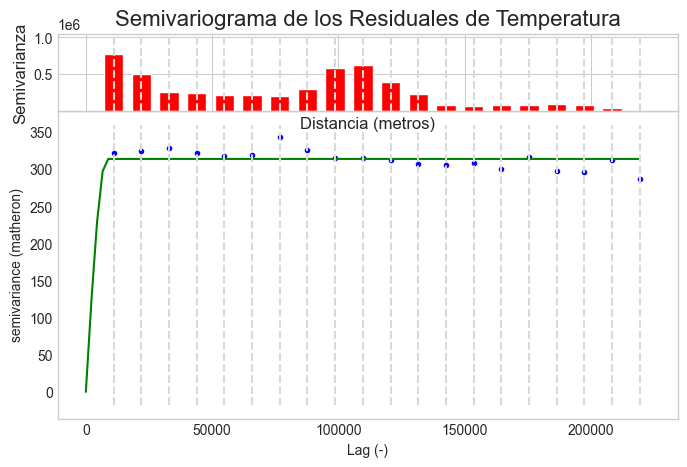


--- SEMIVARIOGRAMA PARA LOS RESIDUALES DE HUMEDAD ---


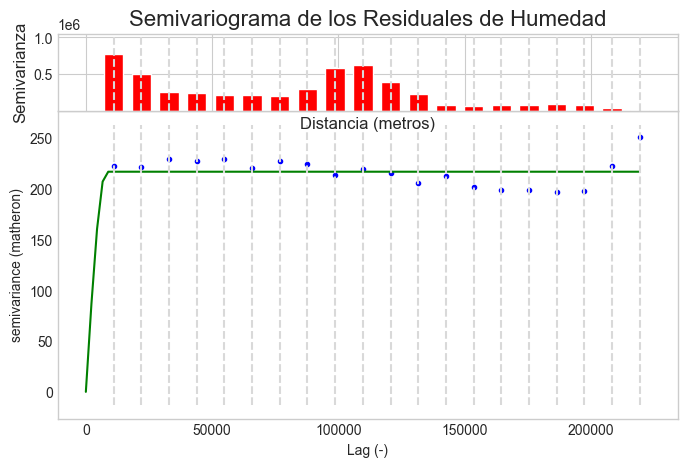

In [9]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt

# Se asume que el DataFrame 'df_base' ya existe desde la celda anterior.

# --- PASO 2: PREPARACIÓN DE DATOS PARA EL ANÁLISIS ---
print("Preparando datos para el análisis de semivariograma...")

coordinates = df_base[['Este', 'Norte']].values
temp_residuals_values = df_base['res_temperatura'].values
hum_residuals_values = df_base['res_humedad'].values

print(f"Datos listos. Se analizarán {len(df_base)} puntos.")


# --- PASO 3: ANÁLISIS DE SEMIVARIOGRAMA PARA RESIDUALES DE TEMPERATURA ---
print("\n" + "="*60)
print("--- SEMIVARIOGRAMA PARA LOS RESIDUALES DE TEMPERATURA ---")
print("="*60)

V_temp = skg.Variogram(
    coordinates=coordinates,
    values=temp_residuals_values,
    n_lags=20,
    fit_method='trf'
)

fig = V_temp.plot(show=False)
plt.title('Semivariograma de los Residuales de Temperatura', fontsize=16)
plt.xlabel('Distancia (metros)', fontsize=12)
plt.ylabel('Semivarianza', fontsize=12)
plt.grid(True)
plt.show()


# --- PASO 4: ANÁLISIS DE SEMIVARIOGRAMA PARA RESIDUALES DE HUMEDAD ---
print("\n" + "="*60)
print("--- SEMIVARIOGRAMA PARA LOS RESIDUALES DE HUMEDAD ---")
print("="*60)

V_hum = skg.Variogram(
    coordinates=coordinates,
    values=hum_residuals_values,
    n_lags=20,
    fit_method='trf'
)

fig = V_hum.plot(show=False)
plt.title('Semivariograma de los Residuales de Humedad', fontsize=16)
plt.xlabel('Distancia (metros)', fontsize=12)
plt.ylabel('Semivarianza', fontsize=12)
plt.grid(True)
plt.show()
